# **Fitted trend in rx2day with multiple covariates**

In [12]:
source("../wwa_model-fitting.R")

---
## **Exploratory analysis**

### **Include TCs in model fit?**

In [ ]:
df = read.csv("ts/rx2day-jj_composite.csv")
df$log_rx2day <- log(df$rx2day)
df$log_rx2day_notc <- log(df$rx2day_notc)
gmst_2023 <- df$gmst[df$year == 2023]

mdl_gev <- fit_ns("gev", "fixeddisp", df, "rx2day", "gmst", lower = F)
mdl_gev_notc <- fit_ns("gev", "fixeddisp", df, "rx2day_notc", "gmst", lower = F)

mdl_lnorm <- fit_ns("norm", "shift", df, "log_rx2day", "gmst", lower = F)
mdl_lnorm_notc <- fit_ns("norm", "shift", df, "log_rx2day_notc", "gmst", lower = F)

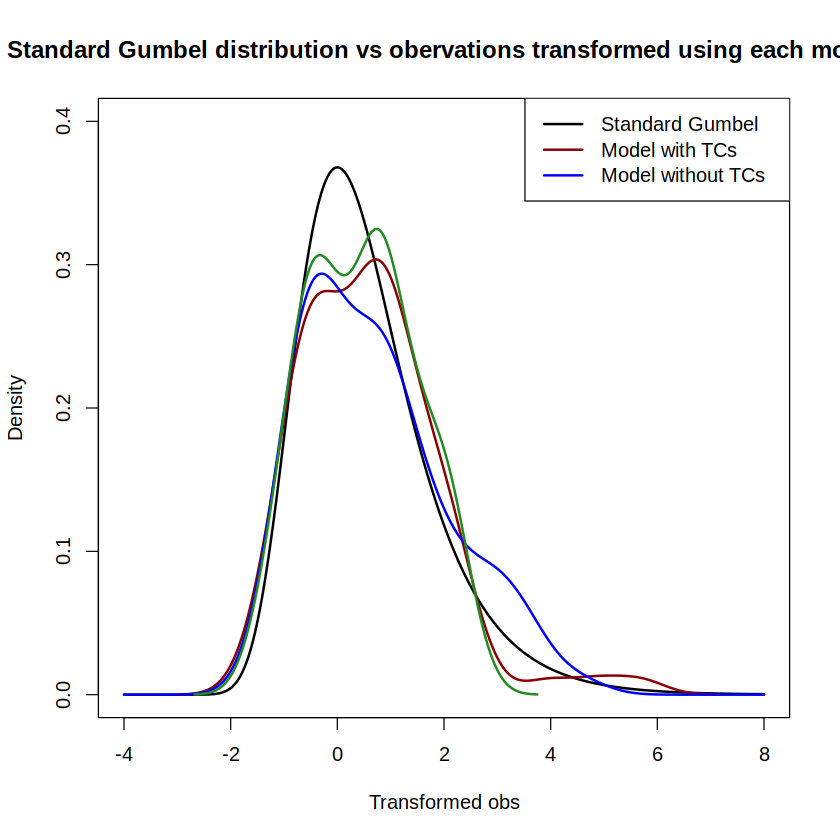

In [6]:
plot(seq(-4,8,0.01), devd(seq(-4,8,0.01)), lwd = 2, ylim = c(0,0.4), type = "l", xlab = "Transformed obs", ylab = "Density",
     main = "Standard Gumbel distribution vs obervations transformed using each model")
lines(density(qevd(pevd(df$rx2day, loc = mdl_gev$par["mu0"], scale = mdl_gev$par["sigma0"], shape = mdl_gev$par["shape"]))), lwd = 2, col = "darkred")
lines(density(qevd(pevd(df$rx2day_notc, loc = mdl_gev_notc$par["mu0"], scale = mdl_gev_notc$par["sigma0"], shape = mdl_gev_notc$par["shape"])), from = -4, to = 8), lwd = 2, col = "blue")

lines(density(qevd(pevd(df$rx2day_notc, loc = mdl_gev$par["mu0"], scale = mdl_gev$par["sigma0"], shape = mdl_gev$par["shape"]))), lwd = 2, col = "forestgreen")

legend("topright", legend = c("Standard Gumbel", "Model with TCs", "Model without TCs"), lty = 1, lwd = 2, col = c("black", "darkred", "blue"))

In [190]:
prep_window(c(1,2))

png(paste0("fig/fitted-gev_gmst_with-or-without-TCs.png"), height = 480 * 1, width = 480 * 2); par(mfrow = c(1,2), oma = c(0,0,0,0), cex = 1.4); {
    plot_returnlevels(mdl_gev, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = "bottomright", main = "With TCs", ylim = yl)
    plot_returnlevels(mdl_gev_notc, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = "bottomright", main = "Without TCs", ylim = yl)
}; dev.off()

png 
  2

## **Fitted models**

### **1935-2023 vs 1980-2023**

In [260]:
df = read.csv("ts/rx2day-jj_composite.csv")[,c("year", "rx2day", "rx2day_notc", "gmst", "ipo", "nino34")]
df$rx2day_withTC <- df$rx2day
gmst_2023 <- df$gmst[df$year == 2023]
cg <- df$rx2day[df$year == 2023]

In [262]:
mdl_1935 <- fit_ns("gev", "fixeddisp", df, "rx2day", "gmst", lower = F, ev = cg)
mdl_1980 <- fit_ns("gev", "fixeddisp", df[df$year >= 1980,], "rx2day", "gmst", lower = F, ev = cg)
mdl_1940 <- fit_ns("gev", "fixeddisp", df[df$year >= 1940,], "rx2day", "gmst", lower = F, ev = cg)

cov <- gmst_2023; cov_cf <- gmst_2023 - 1.2

In [228]:
lr.test(fevd(rx2day, df), fevd(rx2day, df, location.fun = ~gmst))  # actually no evidence that including GMST as a covariate improves the fit of the model


	Likelihood-ratio Test

data:  rx2dayrx2day
Likelihood-ratio = 0.076986, chi-square critical value = 3.8415, alpha
= 0.0500, Degrees of Freedom = 1.0000, p-value = 0.7814
alternative hypothesis: greater


In [229]:
lr.test(fevd(rx2day, df[df$year >= 1980,]), fevd(rx2day, df[df$year >= 1980,], location.fun = ~gmst))  # still true even when we look from 1980 onwards


	Likelihood-ratio Test

data:  rx2dayrx2day
Likelihood-ratio = 0.42292, chi-square critical value = 3.8415, alpha =
0.0500, Degrees of Freedom = 1.0000, p-value = 0.5155
alternative hypothesis: greater


In [230]:
mu_ci <- lapply(list("mdl_1935" = mdl_1935, "mdl_1980" = mdl_1980), function(mdl) {
    mdl_df <- mdl$data
    set.seed(42)
    mu_ci <- apply(sapply(1:1000, function(i) {
        boot_df <- mdl_df[sample(1:nrow(mdl_df), nrow(mdl_df), replace = T),]
        tryCatch({
            boot_mdl <- refit(mdl, boot_df)
            c("mu_ev" = ns_pars(boot_mdl, fixed_cov = cov)$loc,
              "mu_cf" = ns_pars(boot_mdl, fixed_cov = cov_cf)$loc)
        }, error = function(cond) {return(rep(NA, 2))})
    }), 1, quantile, c(0.025, 0.975), na.rm = T)
})

In [231]:
prep_window(c(2,2))

png(paste0("fig/fitted-gev_gmst_with-TCs.png"), height = 480 * 2, width = 480 * 2); par(mfrow = c(2,2), oma = c(0,0,0,0), cex = 1.4); {

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plot_trend(mdl_1935, ylim = yl, main = "Fitted trend over time", ev_year = 2023)

    lines(mdl_1980$data$year, ns_pars(mdl_1980)$loc, col = "darkred", lwd = 2)
    matplot(mdl_1980$data$year, eff_return_level(c(6, 40), mdl_1980), type = "l", lty = 1, add = T, col = "red", lwd = c(2, 1))
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plot(df$gmst, df$rx2day, pch = 20, xlim = c(-1.225, 0.025), ylim = yl, xlab = "GMST anomaly", ylab = "rx2day", main = "Fitted trend vs GMST")

    # confidence intervals for mu
    lines(rep(cov, 3), c(ns_pars(mdl_1980, fixed_cov = cov)$loc, mu_ci[["mdl_1980"]][,"mu_ev"]), col = "red", lwd = 2, type = "o", pch = "_")
    lines(rep(cov_cf, 3), c(ns_pars(mdl_1980, fixed_cov = cov_cf)$loc, mu_ci[["mdl_1980"]][,"mu_cf"]), col = "red", lwd = 2, type = "o", pch = "_")

    lines(rep(cov, 3), c(ns_pars(mdl_1935, fixed_cov = cov)$loc, mu_ci[["mdl_1935"]][,"mu_ev"]), col = "black", lwd = 2, type = "o", pch = "_")
    lines(rep(cov_cf, 3), c(ns_pars(mdl_1935, fixed_cov = cov_cf)$loc, mu_ci[["mdl_1935"]][,"mu_cf"]), col = "black", lwd = 2, type = "o", pch = "_")

    # fitted trend model
    lines(mdl_1935$data$gmst, ns_pars(mdl_1935)$loc, col = "black", lwd = 2)
    matplot(mdl_1935$data$gmst, eff_return_level(c(6, 40), mdl_1935), type = "l", lty = 1, add = T, col = "blue", lwd = c(2, 1))

    lines(mdl_1980$data$gmst, ns_pars(mdl_1980)$loc, col = "darkred", lwd = 2)
    matplot(mdl_1980$data$gmst, eff_return_level(c(6, 40), mdl_1980), type = "l", lty = 1, add = T, col = "red", lwd = c(2, 1))

    points(0, cg, col = "magenta", pch = 0, lwd = 2)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plot_returnlevels(mdl_1935, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, ylim = yl, main = "Return levels (1935-2023)", legend_pos = "bottomright")
    plot_returnlevels(mdl_1980, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, ylim = yl, main = "Return levels (1980-2023)", legend_pos = "bottomright")

}; dev.off()


png 
  2

In [263]:
res_1935 <- round(boot_ci(mdl_1935, cov = cov, cov_cf = cov_cf, ev = cg), 2)[c("alpha", "disp", "shape", "return_period", "PR", "dI_rel"),]
res_1980 <- round(boot_ci(mdl_1980, cov = cov, cov_cf = cov_cf, ev = cg), 2)[c("alpha", "disp", "shape", "return_period", "PR", "dI_rel"),]
res_1940 <- round(boot_ci(mdl_1940, cov = cov, cov_cf = cov_cf, ev = cg), 2)[c("alpha", "disp", "shape", "return_period", "PR", "dI_rel"),]

rbind("1935-2023" = data.frame(t(apply(res_1935, 1, function(r) paste0(r[1], " (",r[2],", ",r[3],")")))),
      "1940-2023" = data.frame(t(apply(res_1940, 1, function(r) paste0(r[1], " (",r[2],", ",r[3],")")))),
      "1980-2023" = data.frame(t(apply(res_1980, 1, function(r) paste0(r[1], " (",r[2],", ",r[3],")")))))

,alpha,disp,shape,return_period,PR,dI_rel
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1935-2023,"-1.03 (-15.21, 20.2)","0.29 (0.25, 0.33)","0.09 (-0.12, 0.25)","129.53 (33.86, 1354044.97)","0.91 (0.02, 10.56)","-1.45 (-21.31, 28.52)"
1940-2023,"-0.94 (-15.53, 23.89)","0.28 (0.24, 0.32)","0.07 (-0.1, 0.24)","166.8 (38.01, 20757.38)","0.91 (0.12, 31.01)","-1.32 (-22.23, 32.22)"
1980-2023,"8.02 (-25.57, 51.98)","0.31 (0.22, 0.36)","0.16 (-0.1, 0.55)","48.61 (12.86, 2074.5)","1.67 (0.1, 852.7)","11.7 (-34.18, 86.83)"


### **Effect of excluding TCs**

In [76]:
df = read.csv("ts/rx2day-jj_composite.csv")
gmst_2023 <- df$gmst[df$year == 2023]
cg <- df$rx2day[df$year == 2023]

In [77]:
mdl_gev <- fit_ns("gev", "fixeddisp", df, "rx2day", "gmst", lower = F)
mdl_gev_notc <- fit_ns("gev", "fixeddisp", df, "rx2day_notc", "gmst", lower = F, ev = cg)

In [57]:
mu_ci <- lapply(list("mdl_withTCs" = mdl_gev, "mdl_noTCs" = mdl_gev_notc), function(mdl) {
    mdl_df <- mdl$data
    set.seed(42)
    mu_ci <- apply(sapply(1:1000, function(i) {
        boot_df <- mdl_df[sample(1:nrow(mdl_df), nrow(mdl_df), replace = T),]
        tryCatch({
            boot_mdl <- refit(mdl, boot_df)
            c("mu_ev" = ns_pars(boot_mdl, fixed_cov = gmst_2023)$loc,
              "mu_cf" = ns_pars(boot_mdl, fixed_cov = gmst_2023 - 1.2)$loc)
        }, error = function(cond) {return(rep(NA, 2))})
    }), 1, quantile, c(0.025, 0.975), na.rm = T)
})

#### **1935-2023**

In [59]:
prep_window(c(1,4))
yl <- c(0,350)

png(paste0("fig/fitted-gev_gmst_with-and-without-TCs.png"), height = 480 * 2, width = 480 * 2); par(mfrow = c(2,2), oma = c(0,0,0,0), cex = 1.4); {

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plot(df$year, df$rx2day_notc, type = "s", ylim = yl, lwd = 2, col = adjustcolor("black", alpha = 0.5), xlab = "Year", ylab = "rx2day",
        main = "Fitted trend over time")

    points(2023, cg, pch = 0, col = "magenta", lwd = 2)
    points(df[df$rx2day > 160,c("year", "rx2day")], col = "blue", pch = 4, lwd = 2)

    lines(mdl_gev$data$year, ns_pars(mdl_gev)$loc, col = "darkblue", lwd = 2)
    matplot(mdl_gev$data$year, eff_return_level(c(6, 40), mdl_gev), type = "l", lty = 1, add = T, col = "blue", lwd = c(2, 1))

    lines(mdl_gev_notc$data$year, ns_pars(mdl_gev_notc)$loc, col = "darkred", lwd = 2)
    matplot(mdl_gev_notc$data$year, eff_return_level(c(6, 40), mdl_gev_notc), type = "l", lty = 1, add = T, col = "red", lwd = c(2, 1))

    legend("topleft", legend = c("location", "1-in-6-year event", "1-in-40-year event"), lty = 1, col = c("black", "blue", "blue"), lwd = c(2,2,1))
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plot(df$gmst, df$rx2day_notc, type = "p", pch = 20, xlim = c(-1.225, 0.025), ylim = yl, col = "black", xlab = "GMST anomaly", ylab = "rx2day",
        main = "Fitted trend vs GMST")
    
    points(0, cg, col = "magenta", pch = 0, lwd = 2)
    points(df[df$rx2day > 160,c("gmst", "rx2day")], col = "blue", pch = 4, lwd = 2)
    
    # confidence intervals for mu
    lines(rep(gmst_2023, 3), c(ns_pars(mdl_gev_notc, fixed_cov = gmst_2023)$loc, mu_ci[["mdl_noTCs"]][,"mu_ev"]), col = "red", lwd = 2, type = "o", pch = "_")
    lines(rep(gmst_2023 - 1.2, 3), c(ns_pars(mdl_gev_notc, fixed_cov = gmst_2023 - 1.2)$loc, mu_ci[["mdl_noTCs"]][,"mu_cf"]), col = "red", lwd = 2, type = "o", pch = "_")

    lines(rep(gmst_2023, 3), c(ns_pars(mdl_gev, fixed_cov = gmst_2023)$loc, mu_ci[["mdl_withTCs"]][,"mu_ev"]), col = "black", lwd = 2, type = "o", pch = "_")
    lines(rep(gmst_2023 - 1.2, 3), c(ns_pars(mdl_gev, fixed_cov = gmst_2023 - 1.2)$loc, mu_ci[["mdl_withTCs"]][,"mu_cf"]), col = "black", lwd = 2, type = "o", pch = "_")

    # fitted trend model
    lines(mdl_gev$data$gmst, ns_pars(mdl_gev)$loc, col = "black", lwd = 2)
    matplot(mdl_gev$data$gmst, eff_return_level(c(6, 40), mdl_gev), type = "l", lty = 1, add = T, col = "blue", lwd = c(2, 1))

    lines(mdl_gev_notc$data$gmst, ns_pars(mdl_gev_notc)$loc, col = "darkred", lwd = 2)
    matplot(mdl_gev_notc$data$gmst, eff_return_level(c(6, 40), mdl_gev_notc), type = "l", lty = 1, add = T, col = "red", lwd = c(2, 1))
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plot_returnlevels(mdl_gev, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, ylim = yl, main = "Return levels (including TCs)", legend_pos = "bottomright")
    plot_returnlevels(mdl_gev_notc, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, ylim = yl, main = "Return levels (excluding TCs)", legend_pos = "bottomright")
    
}; dev.off()

png 
  2

In [78]:
res_withTC <- round(boot_ci(mdl_gev, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, ev = cg), 2)[c("alpha", "disp", "shape", "return_period", "PR", "dI_rel"),]
res_noTC <- round(boot_ci(mdl_gev_notc, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, ev = cg, rp = 100), 2)[c("alpha", "disp", "shape", "return_period", "PR", "dI_rel"),]

rbind("With TCs" = data.frame(t(apply(res_withTC, 1, function(r) paste0(r[1], " (",r[2],", ",r[3],")")))),
      "Without TCs" = data.frame(t(apply(res_noTC, 1, function(r) paste0(r[1], " (",r[2],", ",r[3],")")))))

,alpha,disp,shape,return_period,PR,dI_rel
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
With TCs,"-1.03 (-15.21, 20.2)","0.29 (0.25, 0.33)","0.09 (-0.12, 0.25)","129.53 (33.86, 1354044.97)","0.91 (0.02, 10.56)","-1.45 (-21.31, 28.52)"
Without TCs,"-2.94 (-15.94, 13.36)","0.28 (0.24, 0.31)","-0.19 (-0.41, 0)","100 (100, 100)","NaN (0, Inf)","-4.07 (-22.94, 18.01)"


#### **1980-2023**

In [74]:
df = df[df$year >= 1980,]

mdl_gev <- fit_ns("gev", "fixeddisp", df, "rx2day", "gmst", lower = F)
mdl_gev_notc <- fit_ns("gev", "fixeddisp", df, "rx2day_notc", "gmst", lower = F, ev = cg)

In [74]:
mu_ci <- lapply(list("mdl_withTCs" = mdl_gev, "mdl_noTCs" = mdl_gev_notc), function(mdl) {
    mdl_df <- mdl$data
    set.seed(42)
    mu_ci <- apply(sapply(1:1000, function(i) {
        boot_df <- mdl_df[sample(1:nrow(mdl_df), nrow(mdl_df), replace = T),]
        tryCatch({
            boot_mdl <- refit(mdl, boot_df)
            c("mu_ev" = ns_pars(boot_mdl, fixed_cov = gmst_2023)$loc,
              "mu_cf" = ns_pars(boot_mdl, fixed_cov = gmst_2023 - 1.2)$loc)
        }, error = function(cond) {return(rep(NA, 2))})
    }), 1, quantile, c(0.025, 0.975), na.rm = T)
})

In [62]:
prep_window(c(1,4))
yl <- c(0,350)

png(paste0("fig/fitted-gev_gmst_with-and-without-TCs_1980-2023.png"), height = 480 * 2, width = 480 * 2); par(mfrow = c(2,2), oma = c(0,0,0,0), cex = 1.4); {

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plot(df$year, df$rx2day_notc, type = "s", ylim = yl, lwd = 2, col = adjustcolor("black", alpha = 0.5), xlab = "Year", ylab = "rx2day",
        main = "Fitted trend over time")

    points(2023, cg, pch = 0, col = "magenta", lwd = 2)
    points(df[df$rx2day > 160,c("year", "rx2day")], col = "blue", pch = 4, lwd = 2)

    lines(mdl_gev$data$year, ns_pars(mdl_gev)$loc, col = "darkblue", lwd = 2)
    matplot(mdl_gev$data$year, eff_return_level(c(6, 40), mdl_gev), type = "l", lty = 1, add = T, col = "blue", lwd = c(2, 1))

    lines(mdl_gev_notc$data$year, ns_pars(mdl_gev_notc)$loc, col = "darkred", lwd = 2)
    matplot(mdl_gev_notc$data$year, eff_return_level(c(6, 40), mdl_gev_notc), type = "l", lty = 1, add = T, col = "red", lwd = c(2, 1))

    legend("topright", legend = c("location", "1-in-6-year event", "1-in-40-year event"), lty = 1, col = c("black", "blue", "blue"), lwd = c(2,2,1))
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plot(df$gmst, df$rx2day_notc, type = "p", pch = 20, xlim = c(-1.225, 0.025), ylim = yl, col = "black", xlab = "GMST anomaly", ylab = "rx2day",
        main = "Fitted trend vs GMST")
    
    points(0, cg, col = "magenta", pch = 0, lwd = 2)
    points(df[df$rx2day > 160,c("gmst", "rx2day")], col = "blue", pch = 4, lwd = 2)
    
    # confidence intervals for mu
    lines(rep(gmst_2023, 3), c(ns_pars(mdl_gev_notc, fixed_cov = gmst_2023)$loc, mu_ci[["mdl_noTCs"]][,"mu_ev"]), col = "red", lwd = 2, type = "o", pch = "_")
    lines(rep(gmst_2023 - 1.2, 3), c(ns_pars(mdl_gev_notc, fixed_cov = gmst_2023 - 1.2)$loc, mu_ci[["mdl_noTCs"]][,"mu_cf"]), col = "red", lwd = 2, type = "o", pch = "_")

    lines(rep(gmst_2023, 3), c(ns_pars(mdl_gev, fixed_cov = gmst_2023)$loc, mu_ci[["mdl_withTCs"]][,"mu_ev"]), col = "black", lwd = 2, type = "o", pch = "_")
    lines(rep(gmst_2023 - 1.2, 3), c(ns_pars(mdl_gev, fixed_cov = gmst_2023 - 1.2)$loc, mu_ci[["mdl_withTCs"]][,"mu_cf"]), col = "black", lwd = 2, type = "o", pch = "_")

    # fitted trend model
    lines(mdl_gev$data$gmst, ns_pars(mdl_gev)$loc, col = "black", lwd = 2)
    matplot(mdl_gev$data$gmst, eff_return_level(c(6, 40), mdl_gev), type = "l", lty = 1, add = T, col = "blue", lwd = c(2, 1))

    lines(mdl_gev_notc$data$gmst, ns_pars(mdl_gev_notc)$loc, col = "darkred", lwd = 2)
    matplot(mdl_gev_notc$data$gmst, eff_return_level(c(6, 40), mdl_gev_notc), type = "l", lty = 1, add = T, col = "red", lwd = c(2, 1))
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plot_returnlevels(mdl_gev, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, ylim = yl, main = "Return levels (including TCs)", legend_pos = "bottomright")
    plot_returnlevels(mdl_gev_notc, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, ylim = yl, main = "Return levels (excluding TCs)", legend_pos = "bottomright")
    
}; dev.off()

png 
  2

In [75]:
res_withTC <- round(boot_ci(mdl_gev, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, ev = cg), 2)[c("alpha", "disp", "shape", "return_period", "PR", "dI_rel"),]
res_noTC <- round(boot_ci(mdl_gev_notc, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, ev = cg, rp = 100), 2)[c("alpha", "disp", "shape", "return_period", "PR", "dI_rel"),]

rbind("With TCs" = data.frame(t(apply(res_withTC, 1, function(r) paste0(r[1], " (",r[2],", ",r[3],")")))),
      "Without TCs" = data.frame(t(apply(res_noTC, 1, function(r) paste0(r[1], " (",r[2],", ",r[3],")")))))

,alpha,disp,shape,return_period,PR,dI_rel
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
With TCs,"8.02 (-25.57, 51.98)","0.31 (0.22, 0.36)","0.16 (-0.1, 0.55)","48.61 (12.86, 2074.5)","1.67 (0.1, 852.7)","11.7 (-34.18, 86.83)"
Without TCs,"1.79 (-21.32, 37.58)","0.29 (0.21, 0.39)","-0.18 (-1.03, 0.24)","100 (100, 100)","NaN (0, Inf)","2.53 (-29.06, 60.88)"


### **Effect of IPO**

In [109]:
df = read.csv("ts/rx2day-jj_composite.csv")[,c("year", "rx2day", "rx2day_notc", "gmst", "ipo", "nino34")]
df$c <- 1
cg <- df$rx2day[df$year == 2023]

gmst_2023 <- df$gmst[df$year == 2023]

ipo_2023 <- df$ipo[df$year == 2023]
ipo_cf <- -df$ipo[df$year == 2023]

# fitted model with IPO as covariate
mdl_ipo <- fit_ns("gev", "fixeddisp", df, "rx2day_notc", "ipo", ev = cg)
mdl_ipo_1980 <- fit_ns("gev", "fixeddisp", df[df$year >=1980,], "rx2day_notc", "ipo", ev = cg)

#### **Model selection using LR tests**

##### **1935-2023**

In [93]:
# LR tests (shift fit only for ease of checking)
mdls_s <- fevd(rx2day_notc, df)
mdls_gmst <- fevd(rx2day_notc, df, location.fun = ~gmst)
mdls_ipo <- fevd(rx2day_notc, df, location.fun = ~ipo)
mdls_gmst_ipo <- fevd(rx2day_notc, df, location.fun = ~gmst + ipo)

In [94]:
print("Stationary vs ~GMST"); lr.test(mdls_s, mdls_gmst)          # no evidence that GMST should be included as a covariate
cat("\n\n")
print("Stationary vs ~IPO"); lr.test(mdls_s, mdls_ipo)           # actually more evidence in favour of including IPO than GMST
cat("\n\n")
print("~GMST vs ~GMST+IPO"); lr.test(mdls_gmst, mdls_gmst_ipo)    # adding IPO to GMST not *quite* significant

[1] "Stationary vs ~GMST"



	Likelihood-ratio Test

data:  rx2day_notcrx2day_notc
Likelihood-ratio = 0.23068, chi-square critical value = 3.8415, alpha =
0.0500, Degrees of Freedom = 1.0000, p-value = 0.631
alternative hypothesis: greater




[1] "Stationary vs ~IPO"



	Likelihood-ratio Test

data:  rx2day_notcrx2day_notc
Likelihood-ratio = 3.2599, chi-square critical value = 3.8415, alpha =
0.0500, Degrees of Freedom = 1.0000, p-value = 0.07099
alternative hypothesis: greater




[1] "~GMST vs ~GMST+IPO"



	Likelihood-ratio Test

data:  rx2day_notcrx2day_notc
Likelihood-ratio = 3.433, chi-square critical value = 3.8415, alpha =
0.0500, Degrees of Freedom = 1.0000, p-value = 0.0639
alternative hypothesis: greater


##### **1935-2023**

In [95]:
# LR tests (shift fit only for ease of checking)
mdls_s <- fevd(rx2day_notc, df)
mdls_gmst <- fevd(rx2day_notc, df, location.fun = ~gmst)
mdls_ipo <- fevd(rx2day_notc, df, location.fun = ~ipo)
mdls_gmst_ipo <- fevd(rx2day_notc, df, location.fun = ~gmst + ipo)

In [96]:
print("Stationary vs ~GMST"); lr.test(mdls_s, mdls_gmst)          # no evidence that GMST should be included as a covariate
cat("\n\n")
print("Stationary vs ~IPO"); lr.test(mdls_s, mdls_ipo)           # actually more evidence in favour of including IPO than GMST
cat("\n\n")
print("~GMST vs ~GMST+IPO"); lr.test(mdls_gmst, mdls_gmst_ipo)    # adding IPO to GMST not *quite* significant

[1] "Stationary vs ~GMST"



	Likelihood-ratio Test

data:  rx2day_notcrx2day_notc
Likelihood-ratio = 0.23068, chi-square critical value = 3.8415, alpha =
0.0500, Degrees of Freedom = 1.0000, p-value = 0.631
alternative hypothesis: greater




[1] "Stationary vs ~IPO"



	Likelihood-ratio Test

data:  rx2day_notcrx2day_notc
Likelihood-ratio = 3.2599, chi-square critical value = 3.8415, alpha =
0.0500, Degrees of Freedom = 1.0000, p-value = 0.07099
alternative hypothesis: greater




[1] "~GMST vs ~GMST+IPO"



	Likelihood-ratio Test

data:  rx2day_notcrx2day_notc
Likelihood-ratio = 3.433, chi-square critical value = 3.8415, alpha =
0.0500, Degrees of Freedom = 1.0000, p-value = 0.0639
alternative hypothesis: greater


#### **Linear dependence of rx2day on IPO**

In [110]:
prep_window(c(1,3))

yl <- c(0,350)

png(paste0("fig/fitted-gev_ipo-without-TCs_1935-2023.png"), height = 480 * 1, width = 480 * 3); par(mfrow = c(1,3), oma = c(0,0,0,0), cex = 1.4); {

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plot_trend(mdl_ipo, ev_year = 2023, ylim = yl, main = "Fitted trend over time")
    points(df[df$rx2day > 160,c("year", "rx2day")], col = "blue", pch = 4, lwd = 2)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plot_gmsttrend(mdl_ipo, ylim = yl, cov = ipo_2023, cov_cf = ipo_cf, ev = NA, xlab = "IPO", main = "Fitted trend vs IPO")
    points(ipo_2023, cg, pch = 0, col = "magenta", lwd = 2)
    points(df[df$rx2day > 160,c("ipo", "rx2day")], col = "blue", pch = 4, lwd = 2)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plot_returnlevels(mdl_ipo, ylim = yl, cov = ipo_2023, cov_cf = ipo_cf, ev = cg, main = "Return levels (excluding TCs)")
    
}; dev.off()

In [111]:
png(paste0("fig/fitted-gev_ipo-without-TCs_1980-2023.png"), height = 480 * 1, width = 480 * 3); par(mfrow = c(1,3), oma = c(0,0,0,0), cex = 1.4); {

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plot_trend(mdl_ipo_1980, ev_year = 2023, ylim = yl, main = "Fitted trend over time")
    points(df[df$rx2day > 160,c("year", "rx2day")], col = "blue", pch = 4, lwd = 2)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plot_gmsttrend(mdl_ipo_1980, ylim = yl, cov = ipo_2023, cov_cf = ipo_cf, ev = NA, xlab = "IPO", main = "Fitted trend vs IPO")
    points(ipo_2023, cg, pch = 0, col = "magenta", lwd = 2)
    points(df[df$rx2day > 160,c("ipo", "rx2day")], col = "blue", pch = 4, lwd = 2)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plot_returnlevels(mdl_ipo_1980, ylim = yl, cov = ipo_2023, cov_cf = ipo_cf, ev = cg, main = "Return levels (excluding TCs)")
    
}; dev.off()

png 
  2

In [114]:
res_ipo_1935 <- round(boot_ci(mdl_ipo, cov = ipo_2023, cov_cf = 0, ev = cg, rp = 100), 2)[c("alpha", "disp", "shape", "PR", "dI_rel"),]
res_ipo_1980 <- round(boot_ci(mdl_ipo_1980, cov = ipo_2023, cov_cf = 0, ev = cg, rp = 100), 2)[c("alpha", "disp", "shape", "PR", "dI_rel"),]

rbind("1935-2023" = data.frame(t(apply(res_ipo_1935, 1, function(r) paste0(r[1], " (",r[2],", ",r[3],")")))),
      "1980-2023" = data.frame(t(apply(res_ipo_1980, 1, function(r) paste0(r[1], " (",r[2],", ",r[3],")")))))

,alpha,disp,shape,PR,dI_rel
,<chr>,<chr>,<chr>,<chr>,<chr>
1935-2023,"-6.38 (-13.76, 0.65)","0.27 (0.23, 0.3)","-0.2 (-0.42, 0.03)","NaN (0.88, Inf)","9.19 (-0.89, 21.33)"
1980-2023,"-6.69 (-15.89, 4.97)","0.29 (0.2, 0.44)","-0.24 (-1.06, 0.25)","NaN (0.15, Inf)","9.72 (-6.8, 25.2)"


### **Effect of using shorter time series**

In [137]:
df = read.csv("ts/rx2day-jj_composite.csv")[,c("year", "rx2day", "rx2day_notc", "gmst", "ipo", "nino34")]
cg <- df$rx2day[df$year == 2023]
gmst_2023 <- df$gmst[df$year == 2023]

In [270]:
starts <- c(1935, seq(1940,1980,10))
mdl_y <- setNames(lapply(starts, function(y) fit_ns("gev", "fixeddisp", df[df$year >= y,], "rx2day", "gmst", lower = F, ev = cg)), paste0("from_", starts))
                         
cols <- c("black", "blue3", "chartreuse4", "darkgoldenrod2", "firebrick", "magenta")

In [271]:
prep_window(c(1,3))

png(paste0("fig/fitted-gev_gmst_starting-later.png"), height = 480 * 1, width = 480 * 3); par(mfrow = c(1,2), oma = c(0,0,0,0), cex = 1.4); {

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plot(df$year, df$rx2day, type = "s", ylim = yl, lwd = 2, col = adjustcolor("black", alpha = 0.5), xlab = "Year", ylab = "rx2day",
        main = "Fitted trend over time")

    points(2023, cg, pch = 0, col = "magenta", lwd = 2)
    # points(df[df$rx2day > 160,c("year", "rx2day")], col = "blue", pch = 4, lwd = 2)
    
    invisible(sapply(1:length(mdl_y), function(i) {
        mdl <- mdl_y[[i]]
        lines(mdl$data$year, ns_pars(mdl)$loc, col = cols[i], lwd = 3)
        matplot(mdl$data$year, eff_return_level(c(6, 40), mdl), type = "l", lty = 1, add = T, col = cols[i], lwd = c(2, 1))
    }))
    legend("topleft", legend = names(mdl_y), col = cols, lty = 1, ncol = 2, lwd = 3)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plot(df$gmst, df$rx2day, pch = 20, xlim = c(-1.225, 0.025), ylim = yl, xlab = "GMST anomaly", ylab = "rx2day", main = "Fitted trend vs GMST")
    
    points(gmst_2023, cg, pch = 0, col = "magenta", lwd = 2)
    # points(df[df$rx2day > 160,c("gmst", "rx2day")], col = "blue", pch = 4, lwd = 2)
    
    invisible(sapply(1:length(mdl_y), function(i) {
        mdl <- mdl_y[[i]]
        lines(mdl$data$gmst, ns_pars(mdl)$loc, col = cols[i], lwd = 3)
        matplot(mdl$data$gmst, eff_return_level(c(6, 40), mdl), type = "l", lty = 1, add = T, col = cols[i], lwd = c(2, 1))
    }))
}; dev.off()


png 
  2

In [273]:
mdl_y_noTCs <- setNames(lapply(starts, function(y) fit_ns("gev", "fixeddisp", df[df$year >= y,], "rx2day_notc", "gmst", lower = F, ev = cg)), paste0("from_", starts))
                         
png(paste0("fig/fitted-gev_gmst_starting-later_noTCs.png"), height = 480 * 1, width = 480 * 3); par(mfrow = c(1,2), oma = c(0,0,0,0), cex = 1.4); {

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plot(df$year, df$rx2day_notc, type = "s", ylim = yl, lwd = 2, col = adjustcolor("black", alpha = 0.5), xlab = "Year", ylab = "rx2day",
        main = "Fitted trend over time")

    points(2023, cg, pch = 0, col = "magenta", lwd = 2)
    points(df[df$rx2day > 160,c("year", "rx2day")], col = "blue", pch = 4, lwd = 2)
    
    invisible(sapply(1:length(mdl_y), function(i) {
        mdl <- mdl_y_noTCs[[i]]
        lines(mdl$data$year, ns_pars(mdl)$loc, col = cols[i], lwd = 3)
        matplot(mdl$data$year, eff_return_level(c(6, 40), mdl), type = "l", lty = 1, add = T, col = cols[i], lwd = c(2, 1))
    }))
    legend("topleft", legend = names(mdl_y), col = cols, lty = 1, ncol = 2, lwd = 3)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plot(df$gmst, df$rx2day_notc, pch = 20, xlim = c(-1.225, 0.025), ylim = yl, xlab = "GMST anomaly", ylab = "rx2day", main = "Fitted trend vs GMST")
    
    points(gmst_2023, cg, pch = 0, col = "magenta", lwd = 2)
    points(df[df$rx2day > 160,c("gmst", "rx2day")], col = "blue", pch = 4, lwd = 2)
    
    invisible(sapply(1:length(mdl_y), function(i) {
        mdl <- mdl_y_noTCs[[i]]
        lines(mdl$data$gmst, ns_pars(mdl)$loc, col = cols[i], lwd = 3)
        matplot(mdl$data$gmst, eff_return_level(c(6, 40), mdl), type = "l", lty = 1, add = T, col = cols[i], lwd = c(2, 1))
    }))
}; dev.off()

### **Plots of changing parameter estimates over time**

In [4]:
df = read.csv("ts/rx2day-jj_composite.csv")[,c("year", "rx2day", "rx2day_notc", "gmst", "ipo", "nino34")]
cg <- df$rx2day[df$year == 2023]
gmst_2023 <- df$gmst[df$year == 2023]

In [5]:
starts <- seq(1936, 1980)
mdl_y <- setNames(lapply(starts, function(y) fit_ns("gev", "fixeddisp", df[df$year >= y,], "rx2day", "gmst", lower = F, ev = cg)), paste0("from_", starts))

In [21]:
# bootstrap all confidence intervals for all models
boot_res <- abind(sapply(mdl_y, function(mdl) boot_ci(mdl, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, ev = cg, ci = 0.7), simplify = F), rev.along = 0, new.names = starts)
save(boot_res, file = "bootstrapped-parameter-changes_ci70.rdata")

In [30]:
load("bootstrapped-parameter-changes_ci70.rdata")

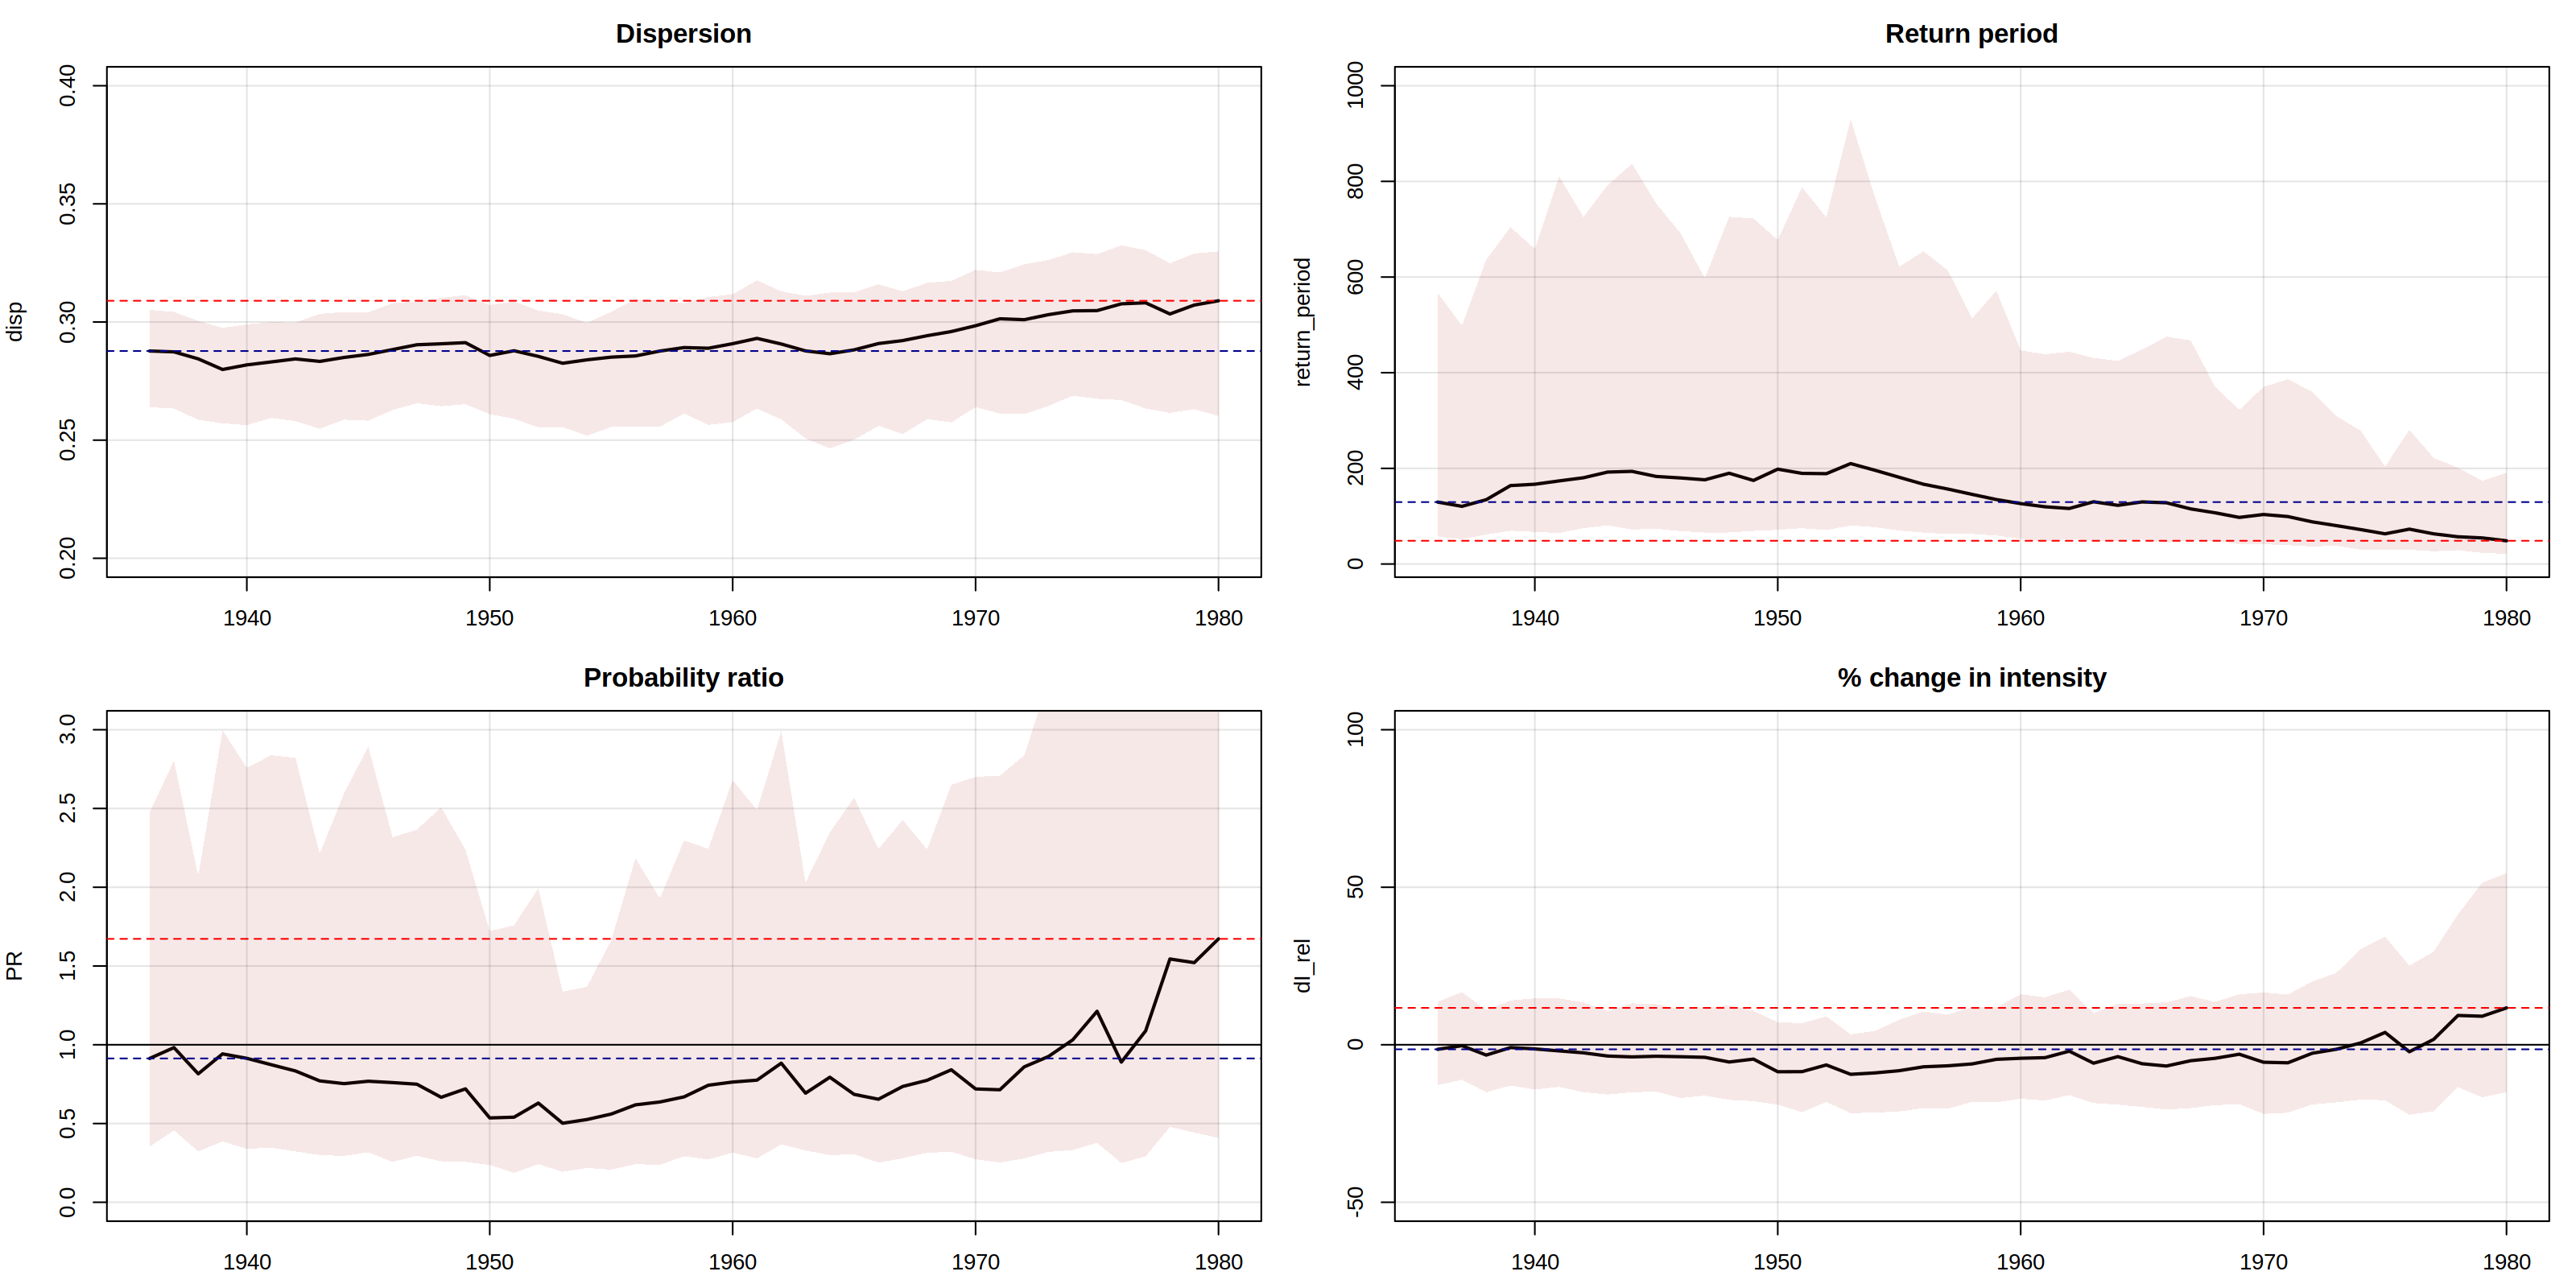

In [31]:
prep_window(c(2,4)); par(mfrow = c(2,2), mar = c(2.5,4,2.5,1))

ylims <- list("disp" = c(0.2,0.4), "return_period" = c(12,1000) , "PR" = c(0,3), "dI_rel" = c(-50,100))
titles <- list("disp" = "Dispersion", "return_period" = "Return period", "PR" = "Probability ratio", "dI_rel" = "% change in intensity")

# png("fig/plots-of-changing-parameters_c90.png", height = 480 * 2, width = 480 * 4); par(mfrow = c(2,2), mar = c(2.5,4,2.5,1), cex = 1.4); {
    for (par in c("disp", "return_period", "PR", "dI_rel")) {
            
        plot(starts, t(boot_res[par,1,]), type = "l", col = "black", ylim = ylims[[par]], lwd = 2, xlab = "", ylab = par, main = titles[[par]])
        polygon(x = c(starts, rev(starts)), y = c(boot_res[par,2,], rev(boot_res[par,3,])), density = NULL, border = NA, col = adjustcolor("firebrick", alpha = 0.1))
        abline(h = (boot_res[par,1,"from_1936"]), lty = 2, col = "darkblue")
        abline(h = (boot_res[par,1,"from_1980"]), lty = 2, col = "red")
        if(par == "PR") abline(h = 1)
        if(par == "dI_rel") abline(h = 0)
        grid(col = adjustcolor("black", 0.1), lty =1)
    }
# }; dev.off()


---
## **Additional analysis**

### **If we use Bayesian parameter estimates, do the TCs become plausible events?**

In [274]:
df = read.csv("ts/rx2day-jj_composite.csv")[,c("year", "rx2day", "rx2day_notc", "gmst", "ipo", "nino34")]
gmst_2023 <- df$gmst[df$year == 2023]
cg <- df$rx2day[df$year == 2023]

In [307]:
# have to compare shift fit but don't think that's going to make much difference
ml_s <- fevd(rx2day_notc, df, location.fun = ~gmst)
mcmc_s <- fevd(rx2day_notc, df, location.fun = ~gmst, method = "Bayesian")

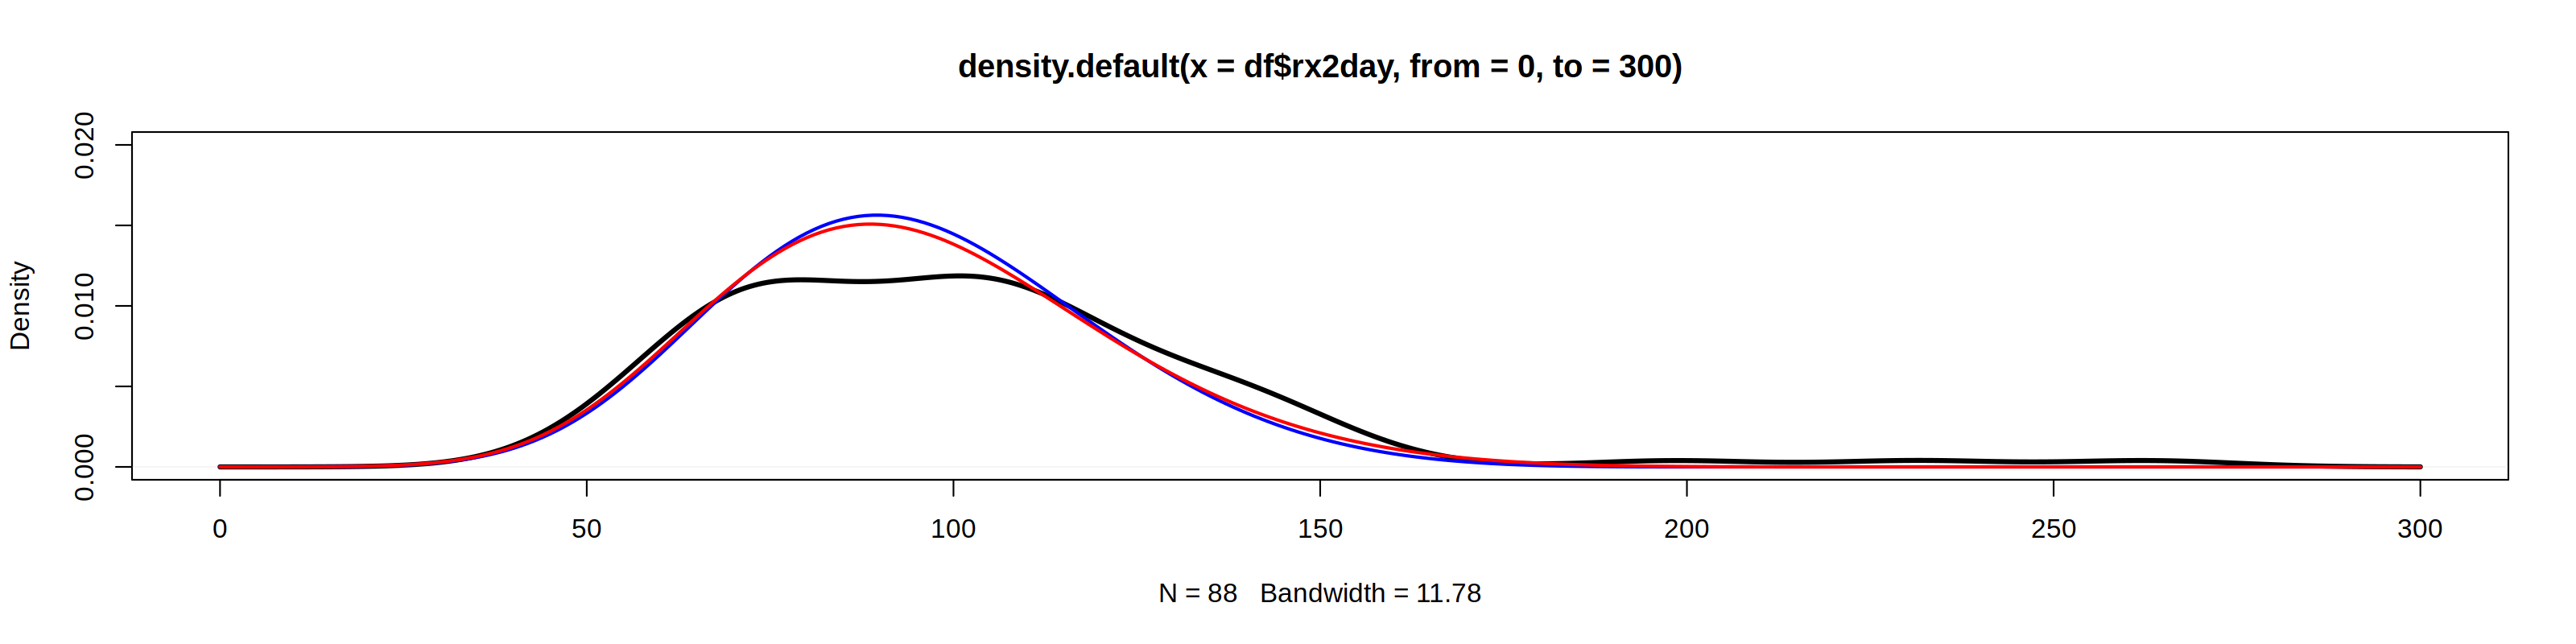

In [309]:
plot(density(df$rx2day, from = 0, to = 300), lwd = 3, ylim = c(0,0.02))
x <- seq(0,300)
lines(x, devd(x, loc = strip(ml_s)["mu0"], scale = strip(ml_s)["scale"], shape = strip(ml_s)["shape"]), col = "blue", lwd = 2)
lines(x, devd(x, loc = strip(mcmc_s)["mu0"], scale = strip(mcmc_s)["scale"], shape = strip(mcmc_s)["shape"]), col = "red", lwd = 2)

In [313]:
# return period of Cyclone Gabrielle
1/(1-pextRemes(ml_s, cg, qcov = make.qcov(ml_s, values = list(mu1 = gmst_2023))))
1/(1-pextRemes(mcmc_s, cg, qcov = make.qcov(ml_s, values = list(mu1 = gmst_2023)))) # sort of.... was actually less improbable when no GMST trend

threshold 
      Inf

threshold 
 13443785

### **What if we use lognormal instead of GEV?**

GEV looks like the better fit, so won't pursue this any further

In [324]:
df = read.csv("ts/rx2day-jj_composite.csv")[,c("year", "rx2day", "rx2day_notc", "gmst", "ipo", "nino34")]
gmst_2023 <- df$gmst[df$year == 2023]
cg <- df$rx2day[df$year == 2023]

df$log_rx2day <- log(df$rx2day)
df$log_rx2day_notc <- log(df$rx2day_notc)

In [336]:
mdl_gev_notc <- fit_ns("gev", "fixeddisp", df, "rx2day_notc", "gmst", lower = F)
mdl_lnorm_notc <- fit_ns("norm", "shift", df, "log_rx2day_notc", "gmst", lower = F)

In [337]:
return_period(mdl_lnorm_notc, log(cg), gmst_2023) # Cyclone Gabrielle not so extreme now

[1] 3053.94

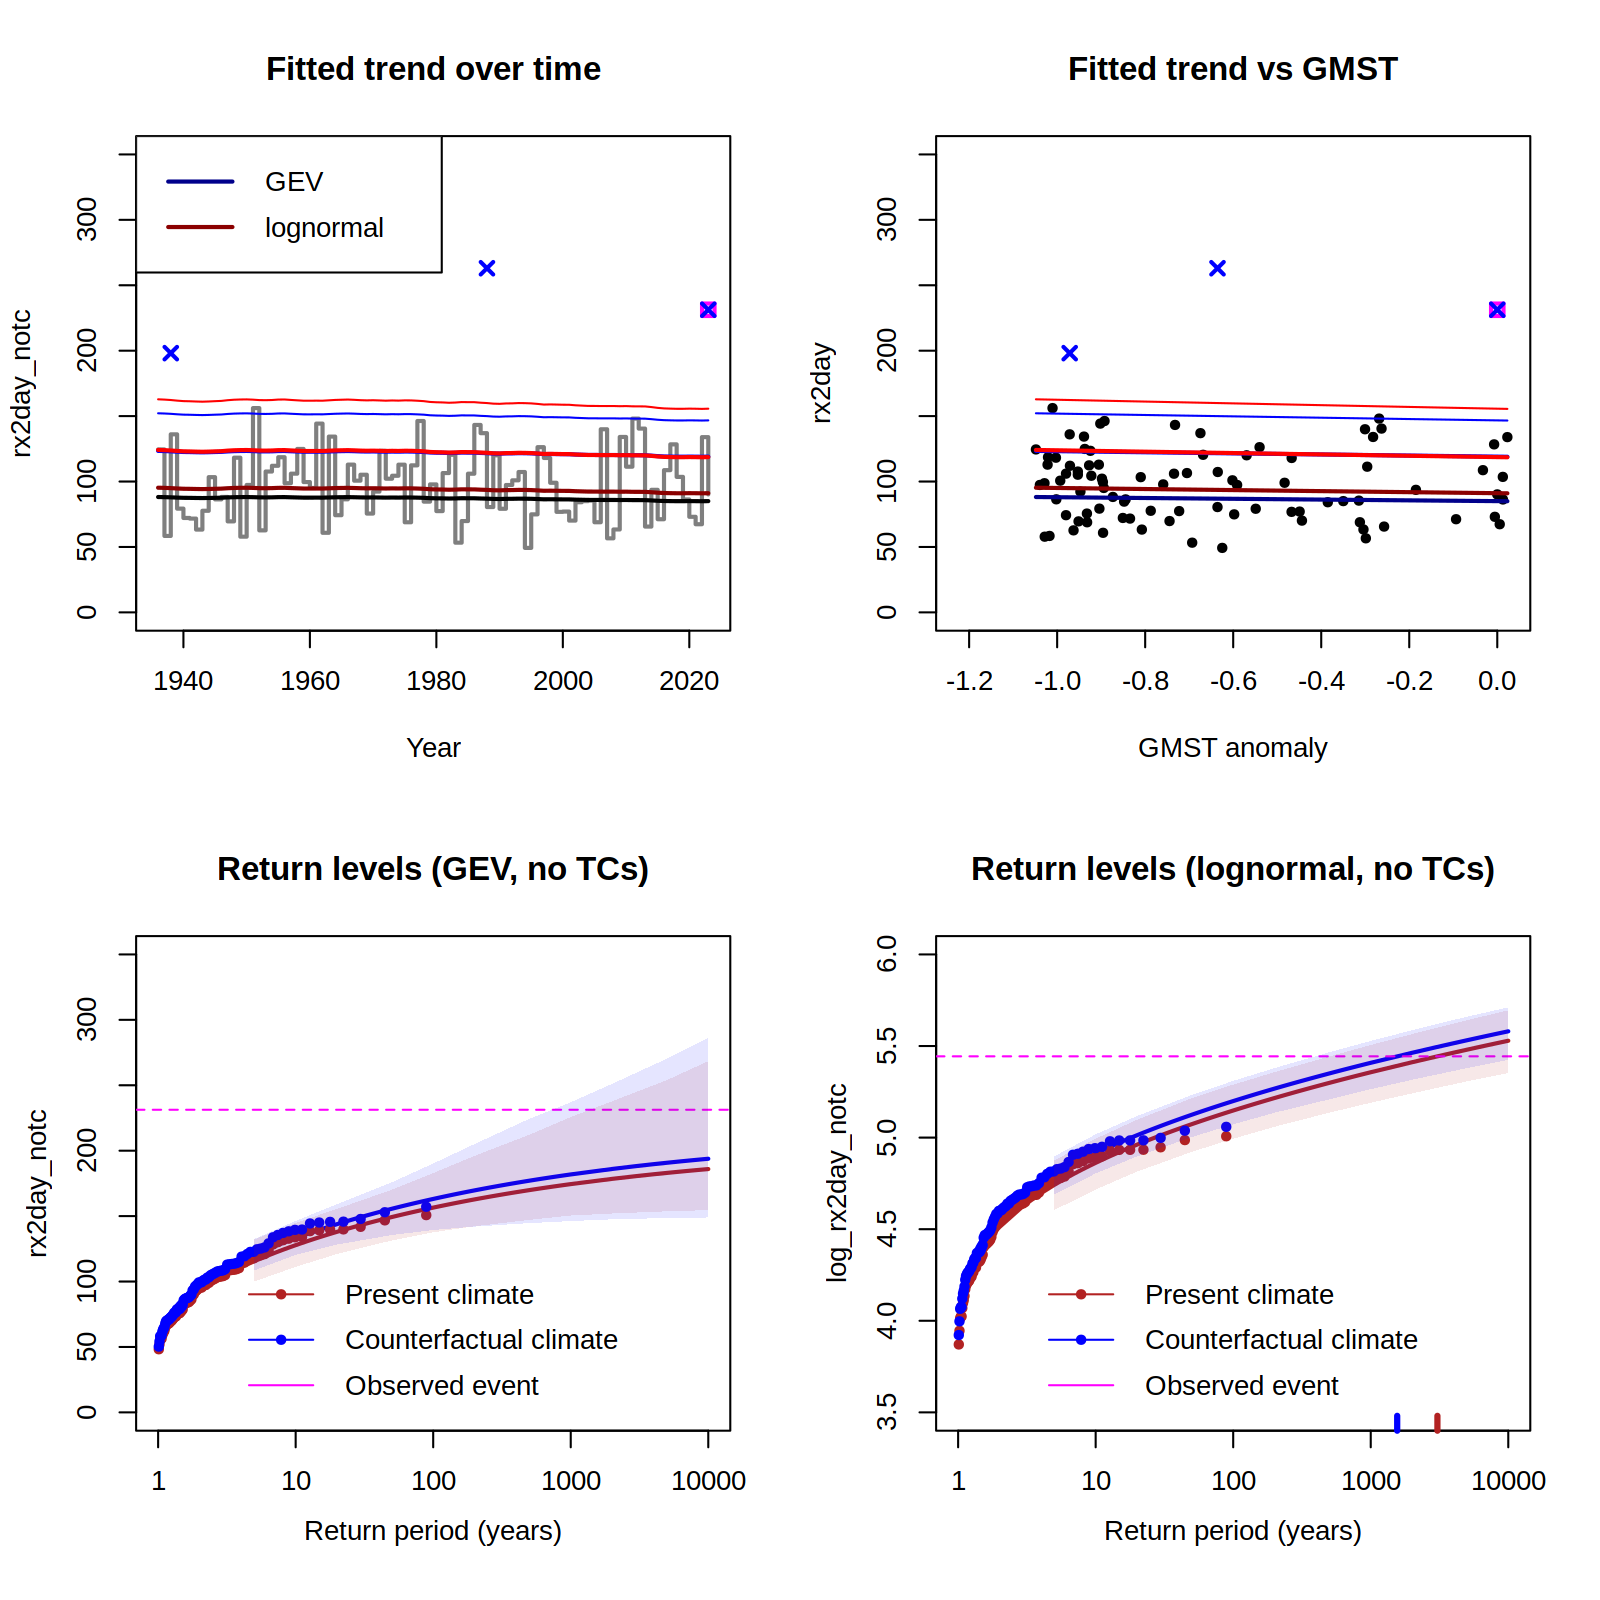

In [348]:
prep_window(c(2,2))

# png(paste0("fig/fitted-lnorm_gmst_without-TCs.png"), height = 480 * 2, width = 480 * 2); par(mfrow = c(2,2), oma = c(0,0,0,0), cex = 1.4); {

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plot_trend(mdl_gev_notc, ylim = yl, main = "Fitted trend over time", ev_year = 2023, ev = NA, legend_pos = NA)

    lines(mdl_lnorm_notc$data$year, exp(ns_pars(mdl_lnorm_notc)$loc), col = "darkred", lwd = 2)
    matplot(mdl_lnorm_notc$data$year, exp(eff_return_level(c(6, 40), mdl_lnorm_notc)), type = "l", lty = 1, add = T, col = "red", lwd = c(2, 1))

    points(2023, cg, pch = 0, col = "magenta", lwd = 2)
    points(df[df$rx2day > 160,c("year", "rx2day")], col = "blue", pch = 4, lwd = 2)
    
    legend("topleft", legend = c("GEV", "lognormal"), col = c("darkblue", "darkred"), lty = 1, lwd = 2)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plot(df$gmst, df$rx2day_notc, pch = 20, xlim = c(-1.225, 0.025), ylim = yl, xlab = "GMST anomaly", ylab = "rx2day", main = "Fitted trend vs GMST")
    
    lines(mdl_gev_notc$data$gmst, (ns_pars(mdl_gev_notc)$loc), col = "darkblue", lwd = 2)
    matplot(mdl_gev_notc$data$gmst, (eff_return_level(c(6, 40), mdl_gev_notc)), type = "l", lty = 1, add = T, col = "blue", lwd = c(2, 1))

    lines(mdl_lnorm_notc$data$gmst, exp(ns_pars(mdl_lnorm_notc)$loc), col = "darkred", lwd = 2)
    matplot(mdl_lnorm_notc$data$gmst, exp(eff_return_level(c(6, 40), mdl_lnorm_notc)), type = "l", lty = 1, add = T, col = "red", lwd = c(2, 1))

    points(gmst_2023, cg, pch = 0, col = "magenta", lwd = 2)
    points(df[df$rx2day > 160,c("gmst", "rx2day")], col = "blue", pch = 4, lwd = 2)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plot_returnlevels(mdl_gev_notc, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, ev = cg, ylim = yl, main = "Return levels (GEV, no TCs)", legend_pos = "bottomright")
    plot_returnlevels(mdl_lnorm_notc, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, ev = log(cg), main = "Return levels (lognormal, no TCs)", legend_pos = "bottomright")

# }; dev.off()


---
---
# **Second phase of analysis**

## **Effect of filtered IPO**

In [134]:
source("../wwa_model-fitting.R")

df = read.csv("ts/rx2day-jj_composite.csv")[,c("year", "rx2day", "rx2day_notc", "gmst", "ipo", "nino34")]

df$c <- 1
cg <- df$rx2day[df$year == 2023]

gmst_2023 <- df$gmst[df$year == 2023]

ipo_f <-  setNames(read.csv("ts/ipo-filt_annual_ersstv5.csv"), c("year", "ipo_f"))
ipo_f$year <- substr(ipo_f$year,1,4)

ipo_2023 <- -0.25
ipo_cf <- 0

df <- merge(df, ipo_f)

In [128]:
# LR tests (shift fit only for ease of checking)
mdls_s <- fevd(rx2day_notc, df)
mdls_gmst <- fevd(rx2day_notc, df, location.fun = ~gmst)
mdls_ipo <- fevd(rx2day_notc, df, location.fun = ~ipo_f)
mdls_gmst_ipo <- fevd(rx2day_notc, df, location.fun = ~gmst + ipo_f)

In [129]:
print("Stationary vs ~GMST"); lr.test(mdls_s, mdls_gmst)          # no evidence that GMST should be included as a covariate
cat("\n\n")
print("Stationary vs ~IPO"); lr.test(mdls_s, mdls_ipo)            # also no evidence in favour of including filtered IPO
cat("\n\n")
print("Stationary vs ~GMST+IPO"); lr.test(mdls_s, mdls_gmst_ipo)  # definitely no evidence to support adding both

[1] "Stationary vs ~GMST"



	Likelihood-ratio Test

data:  rx2day_notcrx2day_notc
Likelihood-ratio = 0.46439, chi-square critical value = 3.8415, alpha =
0.0500, Degrees of Freedom = 1.0000, p-value = 0.4956
alternative hypothesis: greater




[1] "Stationary vs ~IPO"



	Likelihood-ratio Test

data:  rx2day_notcrx2day_notc
Likelihood-ratio = 1.2385, chi-square critical value = 3.8415, alpha =
0.0500, Degrees of Freedom = 1.0000, p-value = 0.2658
alternative hypothesis: greater




[1] "Stationary vs ~GMST+IPO"



	Likelihood-ratio Test

data:  rx2day_notcrx2day_notc
Likelihood-ratio = 1.5281, chi-square critical value = 5.9915, alpha =
0.0500, Degrees of Freedom = 2.0000, p-value = 0.4658
alternative hypothesis: greater


In [130]:
# fitted models scaling with IPO as covariate
mdl_ipo <- fit_ns("gev", "fixeddisp", df, "rx2day_notc", "ipo_f", ev = cg)
mdl_ipo_1980 <- fit_ns("gev", "fixeddisp", df[df$year >= 1980,], "rx2day_notc", "ipo_f", ev = cg)

boot_ipo_1935 <- boot_ci(mdl_ipo, cov = ipo_2023, cov_cf = 0, ev = cg, rp = 100)
boot_ipo_1980 <- boot_ci(mdl_ipo_1980, cov = ipo_2023, cov_cf = 0, ev = cg, rp = 100)

res_ipo_1935 <- round(boot_ipo_1935, 2)[c("alpha", "disp", "shape", "return_period", "PR", "dI_rel"),]
res_ipo_1980 <- round(boot_ipo_1980, 2)[c("alpha", "disp", "shape", "return_period", "PR", "dI_rel"),]

rbind("1935-2023" = data.frame(t(apply(res_ipo_1935, 1, function(r) paste0(r[1], " (",r[2],", ",r[3],")")))),
      "1980-2023" = data.frame(t(apply(res_ipo_1980, 1, function(r) paste0(r[1], " (",r[2],", ",r[3],")")))))

,alpha,disp,shape,return_period,PR,dI_rel
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1935-2023,"-11.32 (-30.45, 8.86)","0.28 (0.23, 0.31)","-0.21 (-0.42, 0.05)","100 (100, 100)","NaN (0.28, Inf)","3.36 (-2.6, 9.85)"
1980-2023,"-13.09 (-37.74, 34.03)","0.3 (0.19, 0.49)","-0.27 (-1.11, 0.37)","100 (100, 100)","NaN (0, Inf)","3.89 (-9.69, 12.05)"


In [131]:
prep_window(c(1,3))

yl <- c(0,350)

png(paste0("fig/fitted-gev_ipo-filtered-without-TCs_1935-2023.png"), height = 480 * 1, width = 480 * 3); par(mfrow = c(1,3), oma = c(0,0,0,0), cex = 1.4); {

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plot_trend(mdl_ipo, ev_year = 2023, ylim = yl, main = "Fitted trend over time")
    points(df[df$rx2day > 160,c("year", "rx2day")], col = "blue", pch = 4, lwd = 2)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plot_gmsttrend(mdl_ipo, ylim = yl, cov = ipo_2023, cov_cf = 0, ev = NA, xlab = "IPO", main = "Fitted trend vs filtered IPO")
    points(ipo_2023, cg, pch = 0, col = "magenta", lwd = 2)
    points(df[df$rx2day > 160,c("ipo_f", "rx2day")], col = "blue", pch = 4, lwd = 2)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plot_returnlevels(mdl_ipo, ylim = yl, cov = ipo_2023, cov_cf = 0, ev = cg, main = "Return levels (excluding TCs)")
    
}; dev.off()

png 
  2

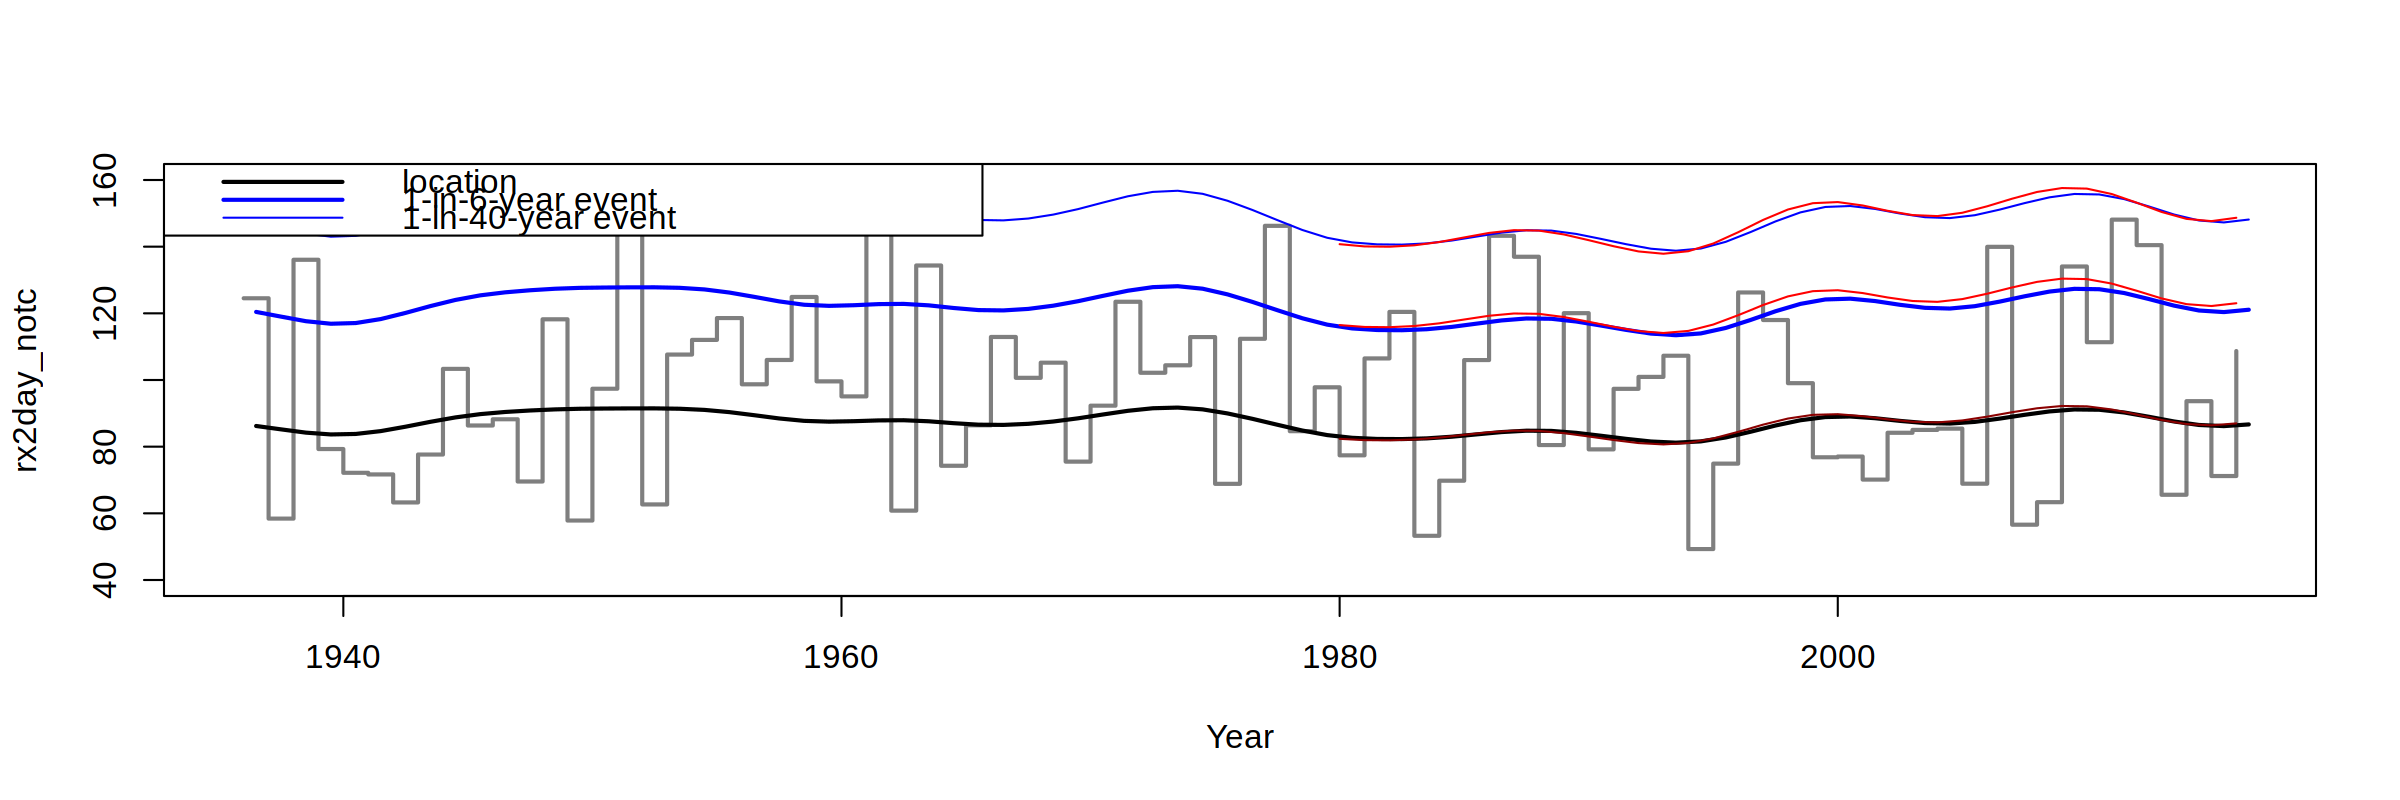

In [132]:
# very similar trends & uncertainties whether fitted to 1935 onwards or 1980 onwards
plot_trend(mdl_ipo)
lines(mdl_ipo_1980$data$year, ns_pars(mdl_ipo_1980)$loc, col = "darkred")
lines(mdl_ipo_1980$data$year, eff_return_level(6, mdl_ipo_1980), col = "red")
lines(mdl_ipo_1980$data$year, eff_return_level(40, mdl_ipo_1980), col = "red")

In [86]:
eff_return_level(6, mdl_ipo_1980)

116.4746
115.9180
115.8429
116.1937
117.0027
118.1455
119.2692
119.9531
119.8495
118.8954
117.4689
